# Soil Thresholding


In [1]:
%matplotlib inline

import sys
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from skimage import exposure, img_as_float, morphology

from osgeo import gdal
import osr
import xml.etree.ElementTree as ET

sys.path.append('D:/')
from my_packages.My_Geoprocess import*

def getNIRTifPath(NetCdf_data_path, endswith='rhos_833.tif'):
    return [f for f in os.listdir(NetCdf_data_path) if f.endswith('rhos_833.tif')]


'''def write_raster2(fname, data, geo_transform, projection, DriverName="GTiff", formatMem=gdal.GDT_UInt16 ):
    """Create a GeoTIFF file with the given data."""
    
    driver = gdal.GetDriverByName(DriverName)
    if driver is None:
        print('DriverFailed')
    
    if len(data.shape)==3:
        rows, cols, NBands = data.shape
    else:
        rows, cols = data.shape
        NBands = 1

    dataset = driver.Create(fname, cols, rows,  NBands, formatMem )
    if driver is None:
        print('DatasetCreation Failed')

    dataset.SetGeoTransform(geo_transform)
    dataset.SetProjection(projection)
    if NBands > 1:
        for b in range(NBands): 
            band = dataset.GetRasterBand(b+1)
            band.WriteArray(data[:,:,b])
    else:
        band = dataset.GetRasterBand(1)
        band.WriteArray(data[:,:])
    dataset = None  # Close the file'''

'def write_raster2(fname, data, geo_transform, projection, DriverName="GTiff", formatMem=gdal.GDT_UInt16 ):\n    """Create a GeoTIFF file with the given data."""\n    \n    driver = gdal.GetDriverByName(DriverName)\n    if driver is None:\n        print(\'DriverFailed\')\n    \n    if len(data.shape)==3:\n        rows, cols, NBands = data.shape\n    else:\n        rows, cols = data.shape\n        NBands = 1\n\n    dataset = driver.Create(fname, cols, rows,  NBands, formatMem )\n    if driver is None:\n        print(\'DatasetCreation Failed\')\n\n    dataset.SetGeoTransform(geo_transform)\n    dataset.SetProjection(projection)\n    if NBands > 1:\n        for b in range(NBands): \n            band = dataset.GetRasterBand(b+1)\n            band.WriteArray(data[:,:,b])\n    else:\n        band = dataset.GetRasterBand(1)\n        band.WriteArray(data[:,:])\n    dataset = None  # Close the file'

# Metadatas extraction, reading and checking

In [ ]:
FilePath = 'D:/SDB/Poe/Images/Acolyte/S2A_MSIL1C_20180305T230901_N0206_R101_T58KEB_20180306T00234_bisAco/S2A_MSI_2018_03_05_23_09_01_T58KEB_L2R_tif/'
image_filePath = getNIRTifPath(FilePath)[0]
gdal.ErrorReset()
ds = gdal.Open( FilePath + image_filePath )

if ds is None or gdal.GetLastErrorMsg() != '':
    print('xml failed to load')
    
    
DataSet_md = ds.GetMetadata()
DataSet_md
NIR = ds.GetRasterBand(1).ReadAsArray()

In [30]:
import inspect
print(inspect.getsource(create_mask_from_vector))

def create_mask_from_vector(vector_data_path, cols, rows, geo_transform,
                            projection, target_value=1, format=gdal.GDT_UInt16):
    """Rasterize the given vector (wrapper for gdal.RasterizeLayer)."""
    data_source = gdal.OpenEx(vector_data_path, gdal.OF_VECTOR)
    layer = data_source.GetLayer(0)
    driver = gdal.GetDriverByName('MEM')  # In memory dataset
    target_ds = driver.Create('', cols, rows, 1, gdal.GDT_UInt16)
    target_ds.SetGeoTransform(geo_transform)
    target_ds.SetProjection(projection)
    gdal.RasterizeLayer(target_ds, [1], layer, burn_values=[target_value])
    return target_ds



<function matplotlib.pyplot.show>

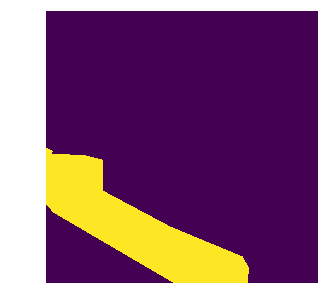

In [3]:
Roi_Path = 'D:/Image/Poe/Shape/ZonePoe32758.shp'

GT = ds.GetGeoTransform()
proj = ds.GetProjection()
rows = ds.RasterXSize
cols = ds.RasterYSize

ROI = create_mask_from_vector(Roi_Path, cols, rows, GT, 
                              proj, target_value=1, format=gdal.GDT_Byte)
ROI= ROI.GetRasterBand(1).ReadAsArray().astype(bool)

plt.figure(figsize=(5, 5))
#plt.subplot(1, 2, 1)
plt.imshow(img_as_float(ROI))
#plt.subplot(1, 2, 2)
#plt.imshow(Random)
plt.axis('off')
plt.show


<function matplotlib.pyplot.show>

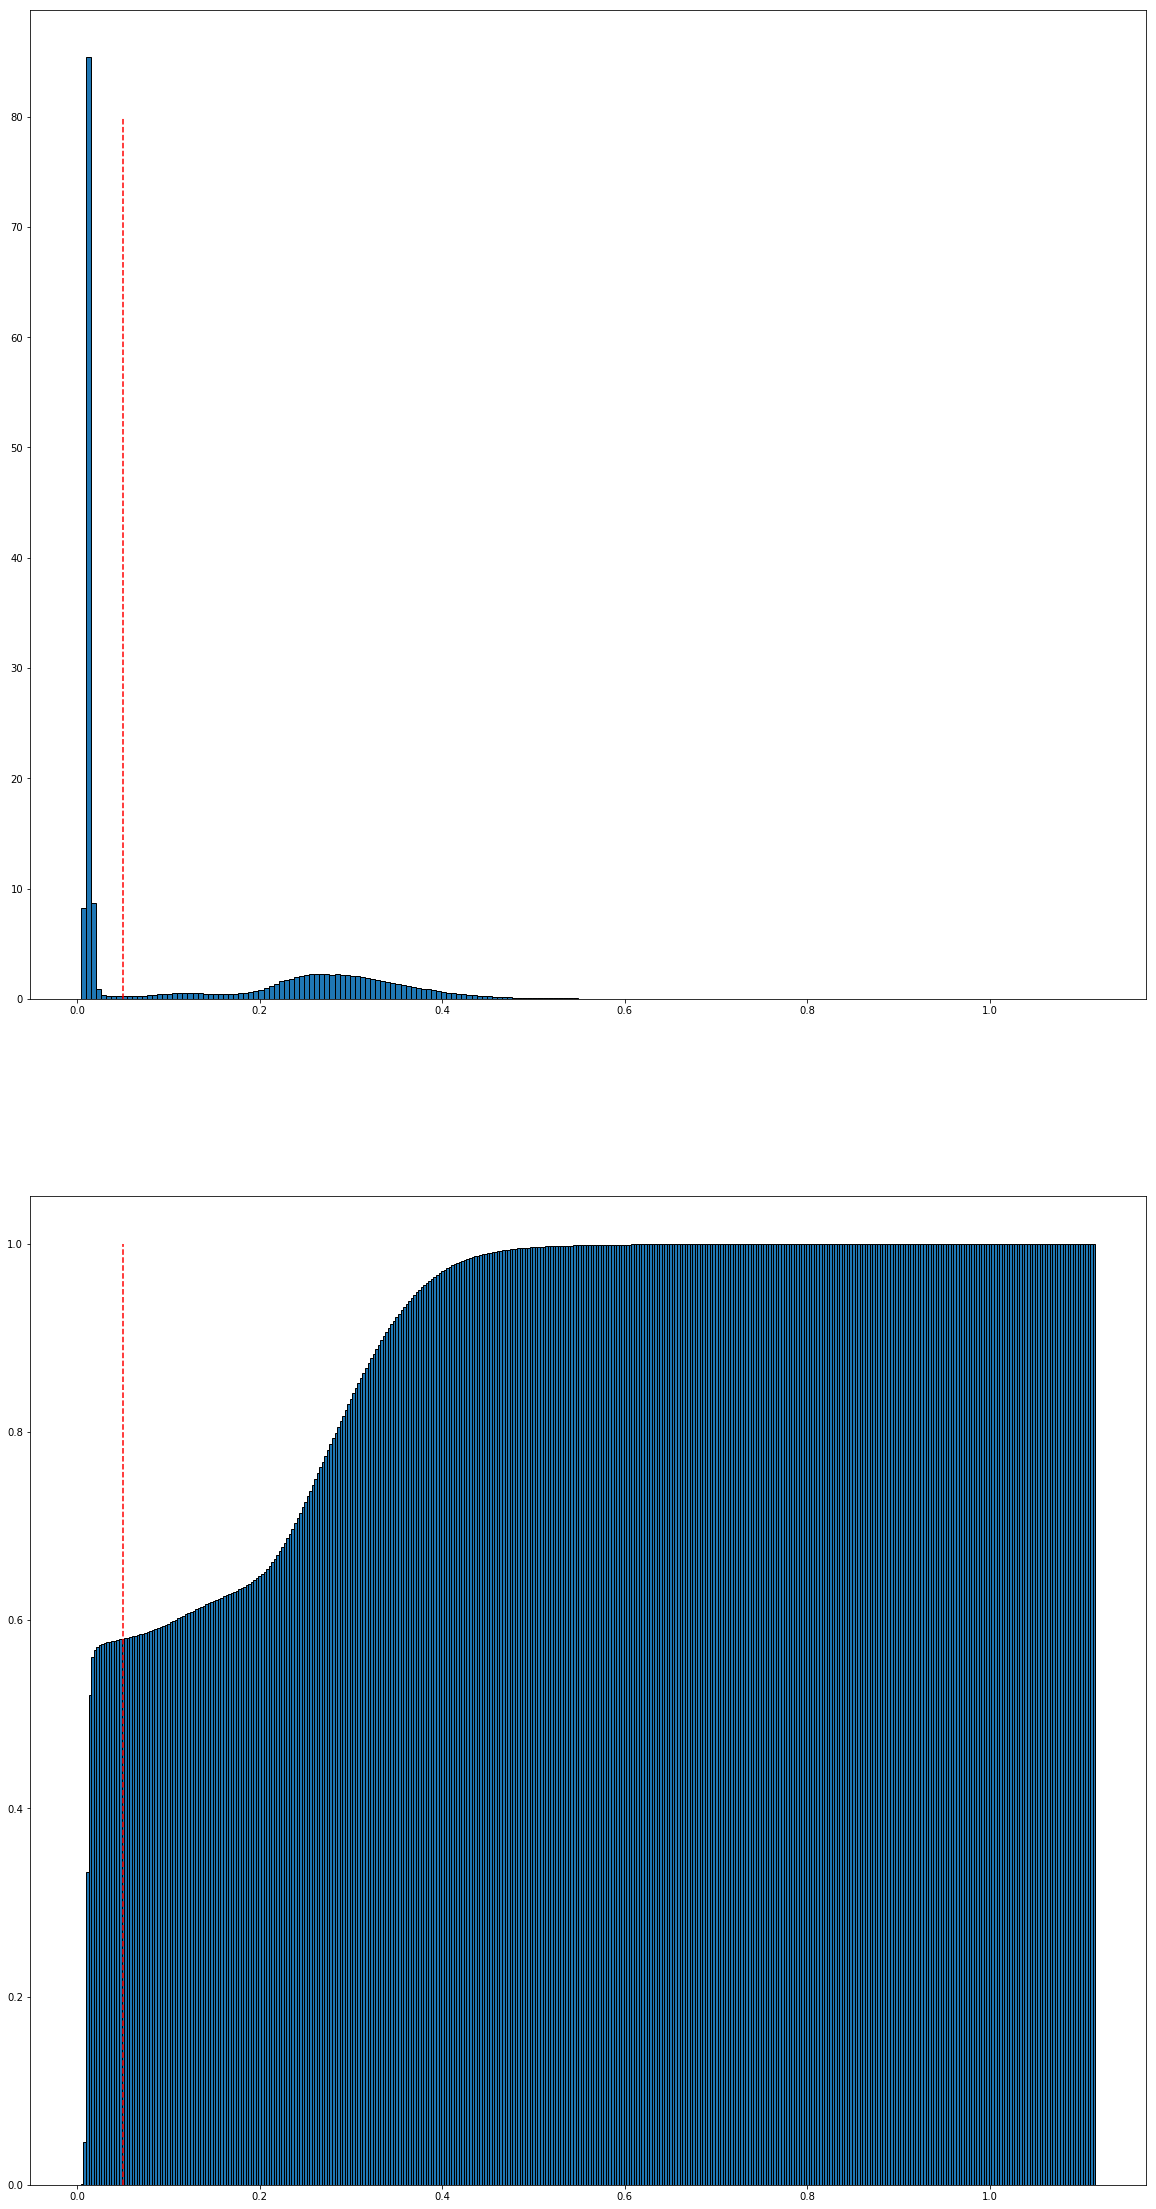

In [9]:
thres = 0.05
plt.figure(figsize=(20, 40))
plt.subplot(2,1,1)
plt.hist(NIR[ROI].ravel(), bins=200, ec='k', normed= True)
plt.plot([thres, thres], [0, 80], 'r--')
plt.show
plt.subplot(2,1,2)
plt.hist(NIR[ROI].ravel(), bins=400, ec='k', normed= True, cumulative= True)
plt.plot([thres, thres], [0, 1], 'r--')
plt.show

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys


<function matplotlib.pyplot.show>

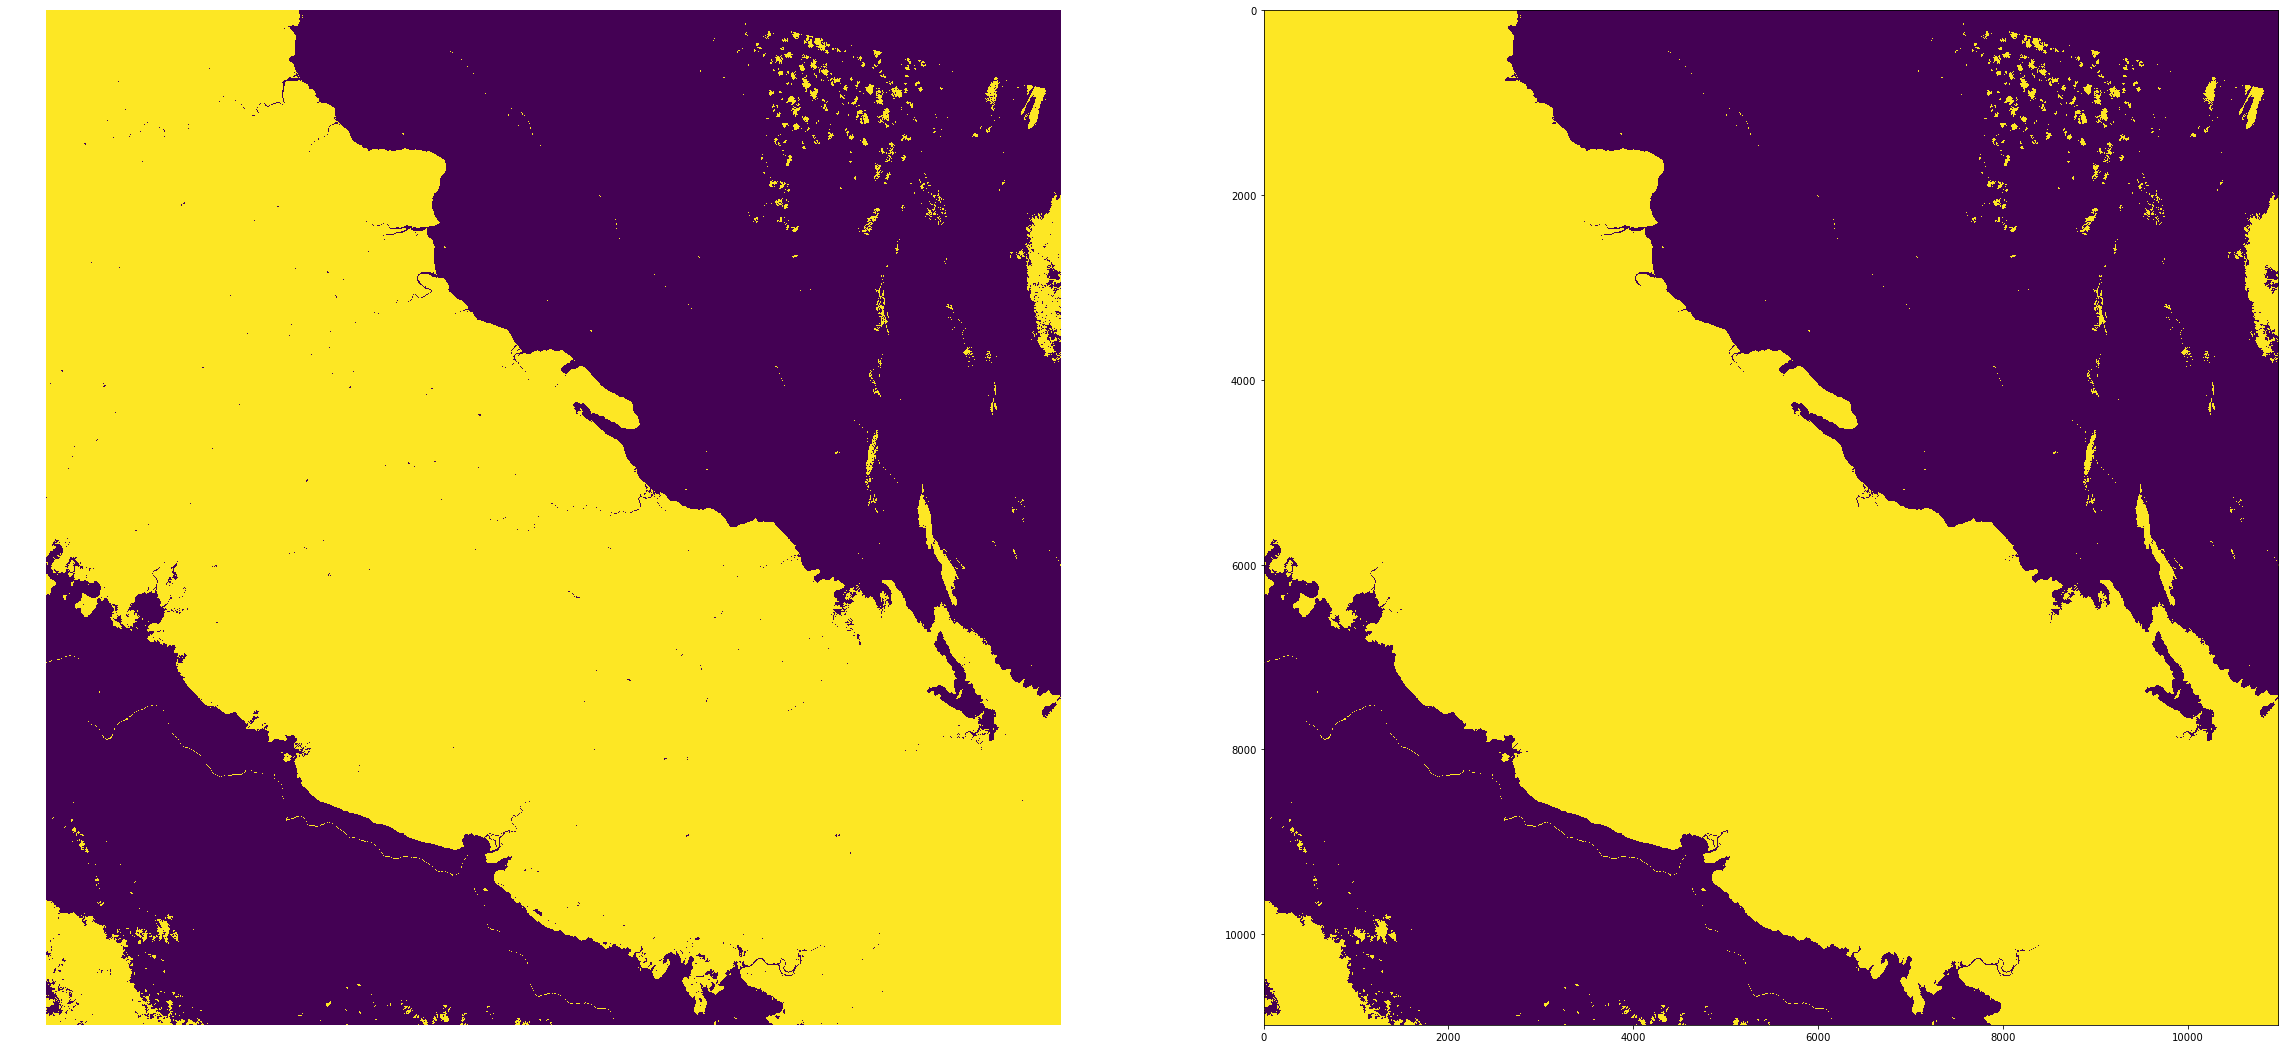

In [12]:

plt.figure(figsize=(40, 40))
plt.subplot(1, 2, 1)
plt.imshow(NIR>0.05)
plt.axis('off')

soilFilled_mask = morphology.remove_small_holes(NIR>0.05,10000)
plt.subplot(1, 2, 2)
plt.imshow(soilFilled_mask)
plt.show

In [14]:
SoilMaskPath = FilePath + 'Mask/SoilMask.tif'
write_raster2(SoilMaskPath, NIR>0.05, GT, proj, DriverName="GTiff", formatMem=gdal.GDT_Byte )

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


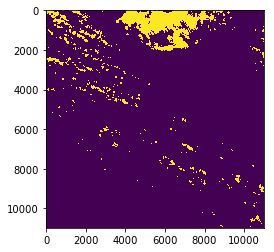

In [31]:
CloudMaskPath = 'D:/Image/Poe/S2B_MSIL1C_20180320T230859_N0206_R101_T58KEB_20180321T002930.SAFE/GRANULE/L1C_T58KEB_A005418_20180320T230859/QI_DATA/'
CloudMaskfile = 'MSK_CLOUDS_B00.gml'
CloudMask = create_mask_from_vector(CloudMaskPath+CloudMaskfile, cols, rows, GT, 
                               proj, target_value=1, format=gdal.GDT_UInt16)
CloudMask= CloudMask.GetRasterBand(1).ReadAsArray()
plt.imshow(img_as_float(CloudMask))

In [32]:
np.unique(CloudMask)

array([0, 1], dtype=uint16)

In [3]:
# Try opening the 4 subdatasets
ds = []
for i in range(4):
    gdal.ErrorReset()
    ds.append(gdal.Open(SubDataSet_md['SUBDATASET_%d_NAME' % (i+1)]))
    print(SubDataSet_md['SUBDATASET_%d_NAME' % (i+1)])
    if ds is None or gdal.GetLastErrorMsg() != '':
        print('subdatasets failed to load')
        print(SubDataSet_md['SUBDATASET_%d_NAME' % (i+1)],'failed')
src_ds = ds[0]
print(ds[0].RasterCount)

SENTINEL2_L1C:C:/Users/samrari/ComputBuffer/Image/Sen2/S2A_MSIL1C_20170718T231141_N0205_R101_T58KFA_20170718T231219.SAFE/MTD_MSIL1C.xml:10m:EPSG_32758
SENTINEL2_L1C:C:/Users/samrari/ComputBuffer/Image/Sen2/S2A_MSIL1C_20170718T231141_N0205_R101_T58KFA_20170718T231219.SAFE/MTD_MSIL1C.xml:20m:EPSG_32758
SENTINEL2_L1C:C:/Users/samrari/ComputBuffer/Image/Sen2/S2A_MSIL1C_20170718T231141_N0205_R101_T58KFA_20170718T231219.SAFE/MTD_MSIL1C.xml:60m:EPSG_32758
SENTINEL2_L1C:C:/Users/samrari/ComputBuffer/Image/Sen2/S2A_MSIL1C_20170718T231141_N0205_R101_T58KFA_20170718T231219.SAFE/MTD_MSIL1C.xml:TCI:EPSG_32758
4


# Detector FootPrint

In [4]:
FootprintFilePath = 'D:/Image/processed/S2A_OPER_PRD_MSIL1C_PDMC_20161101T012450_R101_V20161031T230902_20161031T230902.SAFE/Footprint'
FootprintFilePath
GT = src_ds.GetGeoTransform()
proj = src_ds.GetProjection()
rows = src_ds.RasterXSize
cols = src_ds.RasterYSize
FootPrint = []

for File in GetSimpleFiles("B01*.tif",directory=FootprintFilePath):
    print(File)
    FootPrint.append(create_mask_from_vector(FootprintFilePath + File, cols, rows, GT, \
                                             proj, target_value=1, format=gdal.GDT_Byte))
    
for i in range(len(FootPrint)):
    FootPrint[i] = FootPrint[i].GetRasterBand(1).ReadAsArray().astype(bool)

'''
plt.figure(figsize=(40, 20))
for i in range(1,11):
    plt.subplot(4, 3, i)
    plt.title(str(i))
    plt.imshow(FootPrint[i-1])
    
plt.show
'''
FootPrintBoarders = np.full(FootPrint[0].shape[0:2] , False, dtype= bool)
'''
plt.figure(figsize=(20, 20))
'''
for i in range(1,10):
    '''
    plt.subplot(4, 3, i)
    '''
    FootPrintBoarders[np.logical_and(FootPrint[i-1], FootPrint[i])] = True
    '''
    plt.imshow(np.logical_and(FootPrint[i-1], FootPrint[i]))
    plt.axis('off')'''
    


B02_06.shp
B02_07.shp
B02_08.shp
B02_09.shp
B02_10.shp
B02_11.shp
B02_12.shp
B02_13.shp
B02_14.shp
B02_15.shp


In [20]:
FootprintFilePath = 'D:/Image/processed/S2A_OPER_PRD_MSIL1C_PDMC_20161101T012450_R101_V20161031T230902_20161031T230902.SAFE/Footprint'
FootprintFilePath
GT = src_ds.GetGeoTransform()
proj = src_ds.GetProjection()
rows = src_ds.RasterXSize
cols = src_ds.RasterYSize
FootPrint = []

count = 0
for File in GetSimpleFiles("B02*.tif",directory=FootprintFilePath):
    print(File)
    band = gdal.Open(FootprintFilePath+'/'+File)
    FootPrint.append(band.GetRasterBand(1).ReadAsArray().astype(bool))

'''
plt.figure(figsize=(40, 20))
for i in range(1,11):
    plt.subplot(4, 3, i)
    plt.title(str(i))
    plt.imshow(FootPrint[i-1])
    
plt.show
'''
FootPrintBoarders = np.full(FootPrint[0].shape[0:2] , False, dtype= bool)
'''
plt.figure(figsize=(20, 20))
'''
for i in range(1,7):
    '''
    plt.subplot(4, 3, i)
    '''
    FootPrintBoarders[np.logical_and(FootPrint[i-1], FootPrint[i])] = True
    '''
    plt.imshow(np.logical_and(FootPrint[i-1], FootPrint[i]))
    plt.axis('off')'''
    


B02_06.tif
B02_07.tif
B02_08.tif
B02_09.tif
B02_10.tif
B02_11.tif
B02_12.tif


In [16]:
del band

# Bands assignment and visualization

In [6]:
NIR = src_ds.GetRasterBand(4).ReadAsArray()

RGB_img = np.dstack((src_ds.GetRasterBand(1).ReadAsArray(),\
                     src_ds.GetRasterBand(2).ReadAsArray(),\
                     src_ds.GetRasterBand(3).ReadAsArray()))
better_contrast = np.empty(RGB_img.shape, dtype= RGB_img.dtype)

# Display histograms bands

<function matplotlib.pyplot.show>

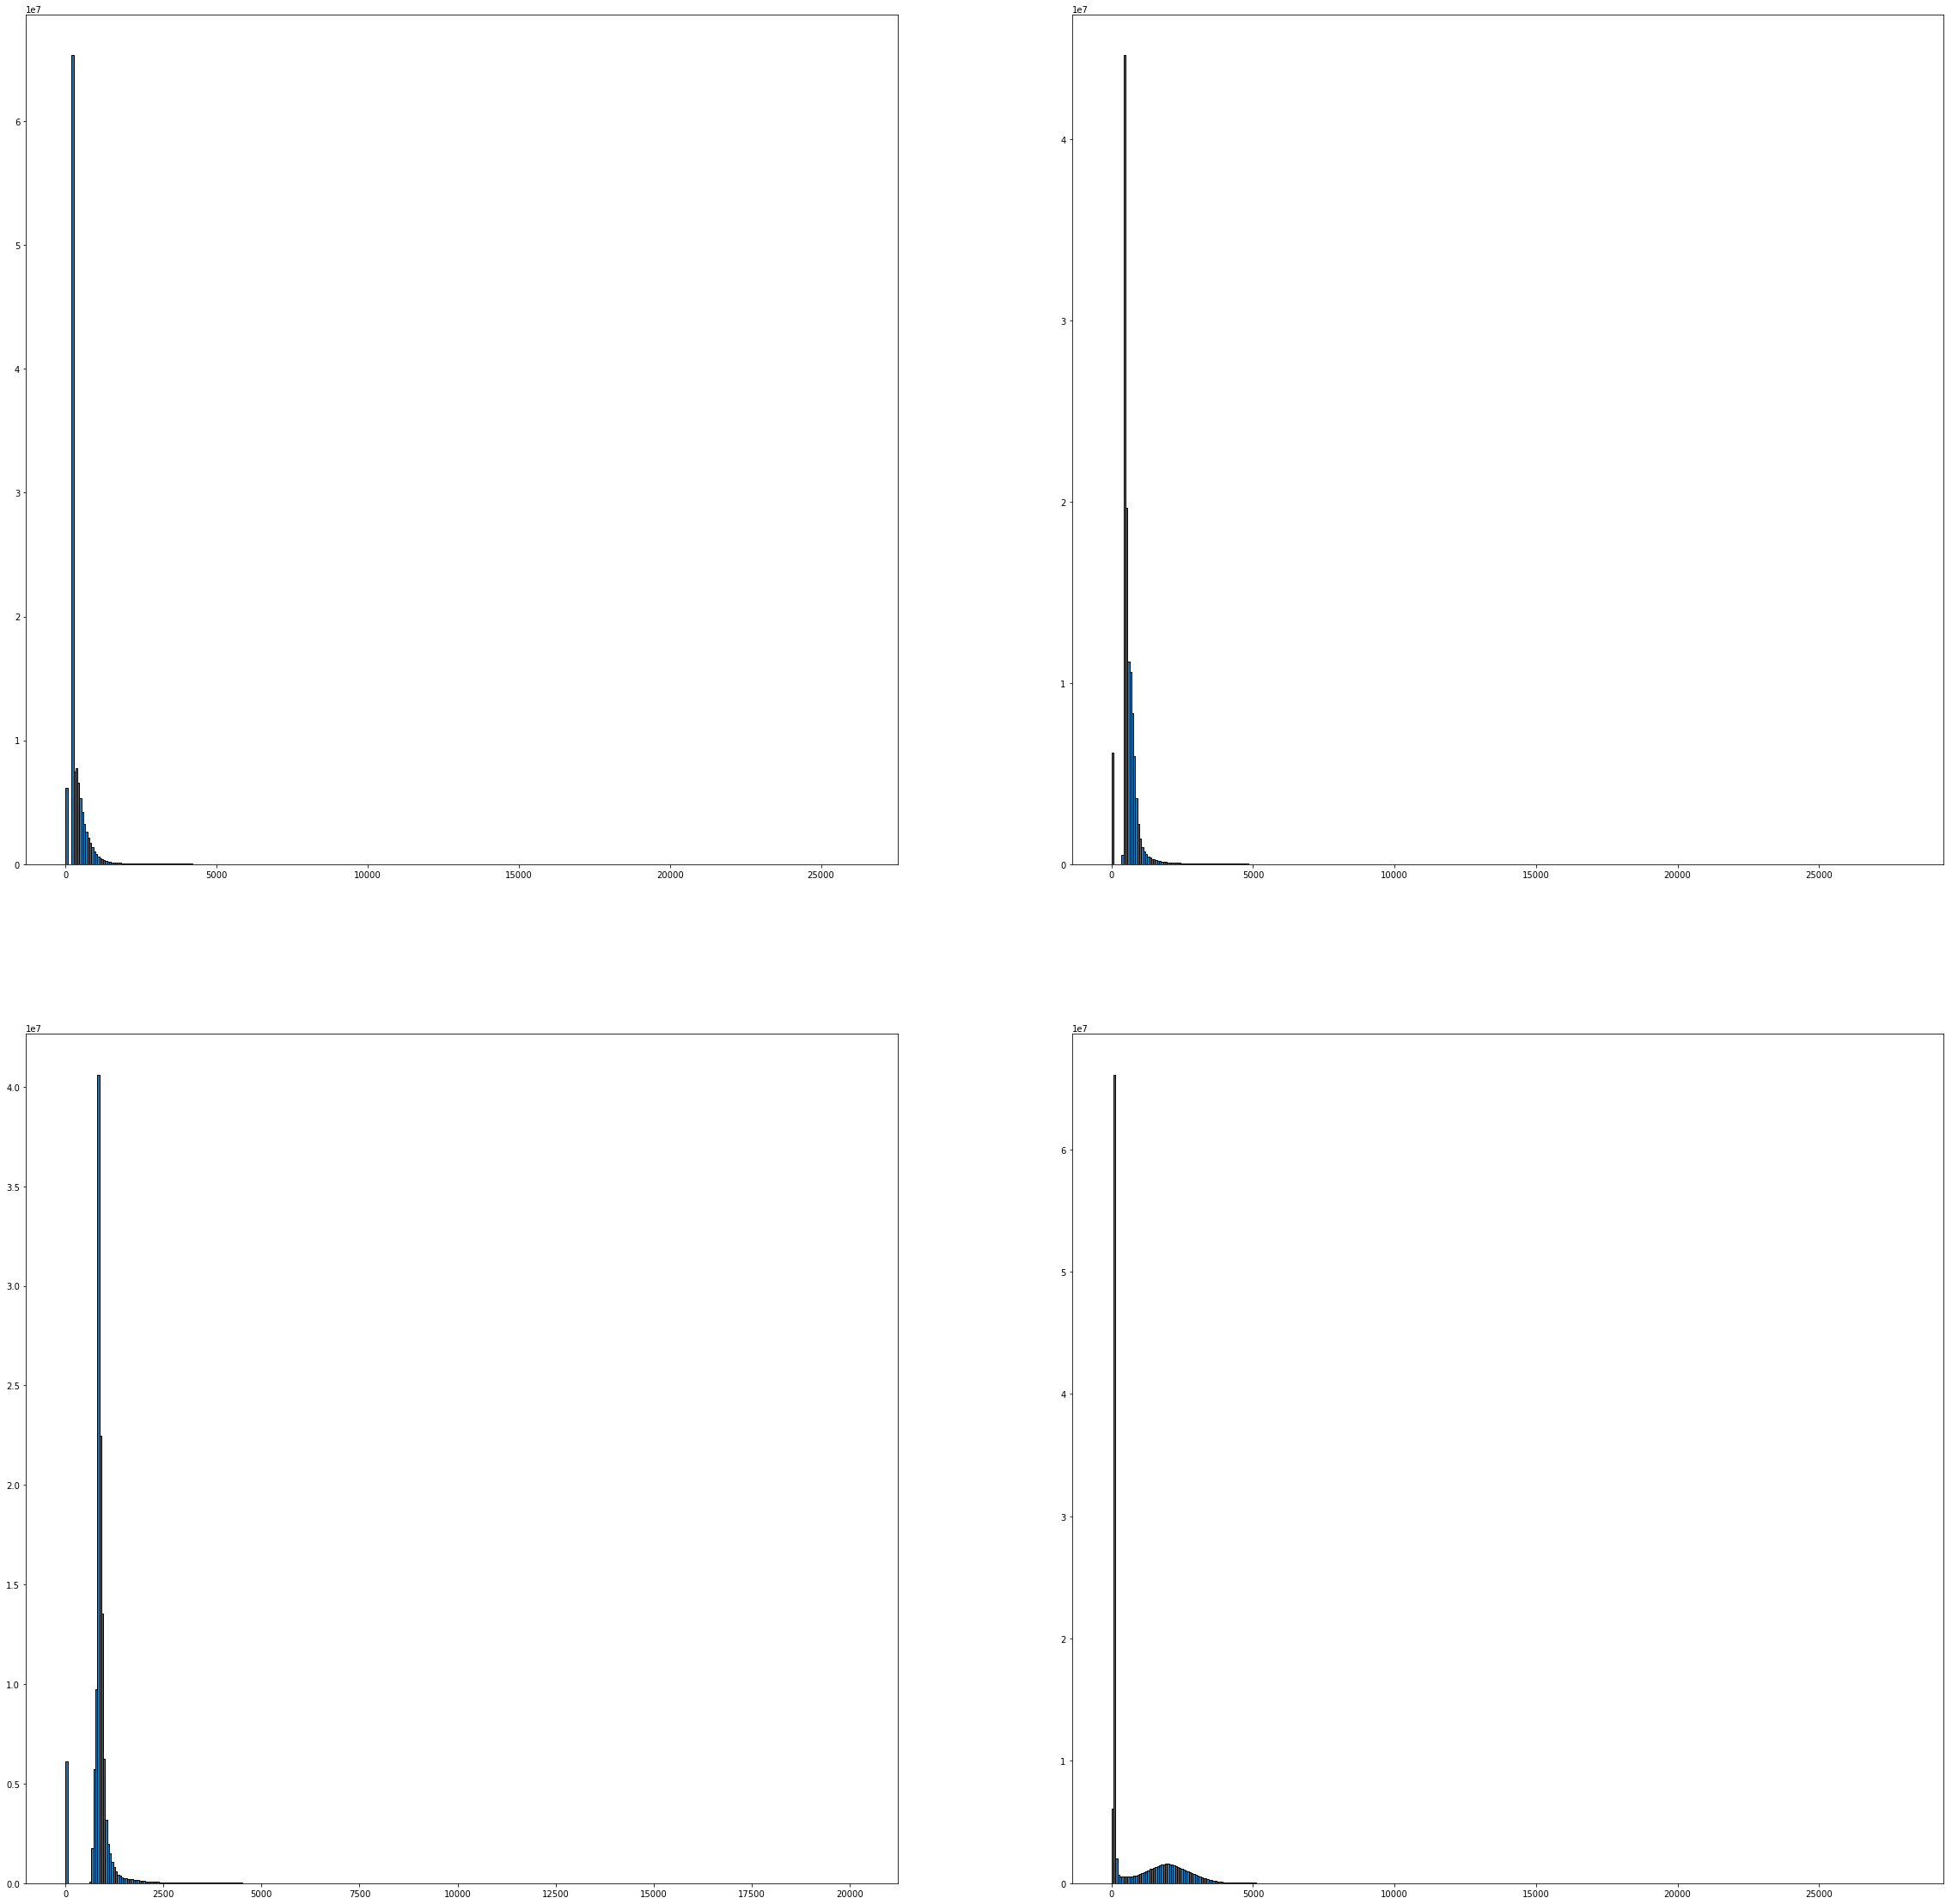

In [8]:
plt.figure(figsize=(40, 40))
for i in range(1,4):  
    plt.subplot(2, 2, i)
    plt.hist(RGB_img[:,:,i-1].ravel(), bins=400, ec='k')

plt.subplot(2, 2, 4)
plt.hist(NIR[:,:].ravel(), bins=400, ec='k')
plt.show

In [9]:
del better_contrast

# NIR soil thresholding and mask cleaning per tiles

<function matplotlib.pyplot.show>

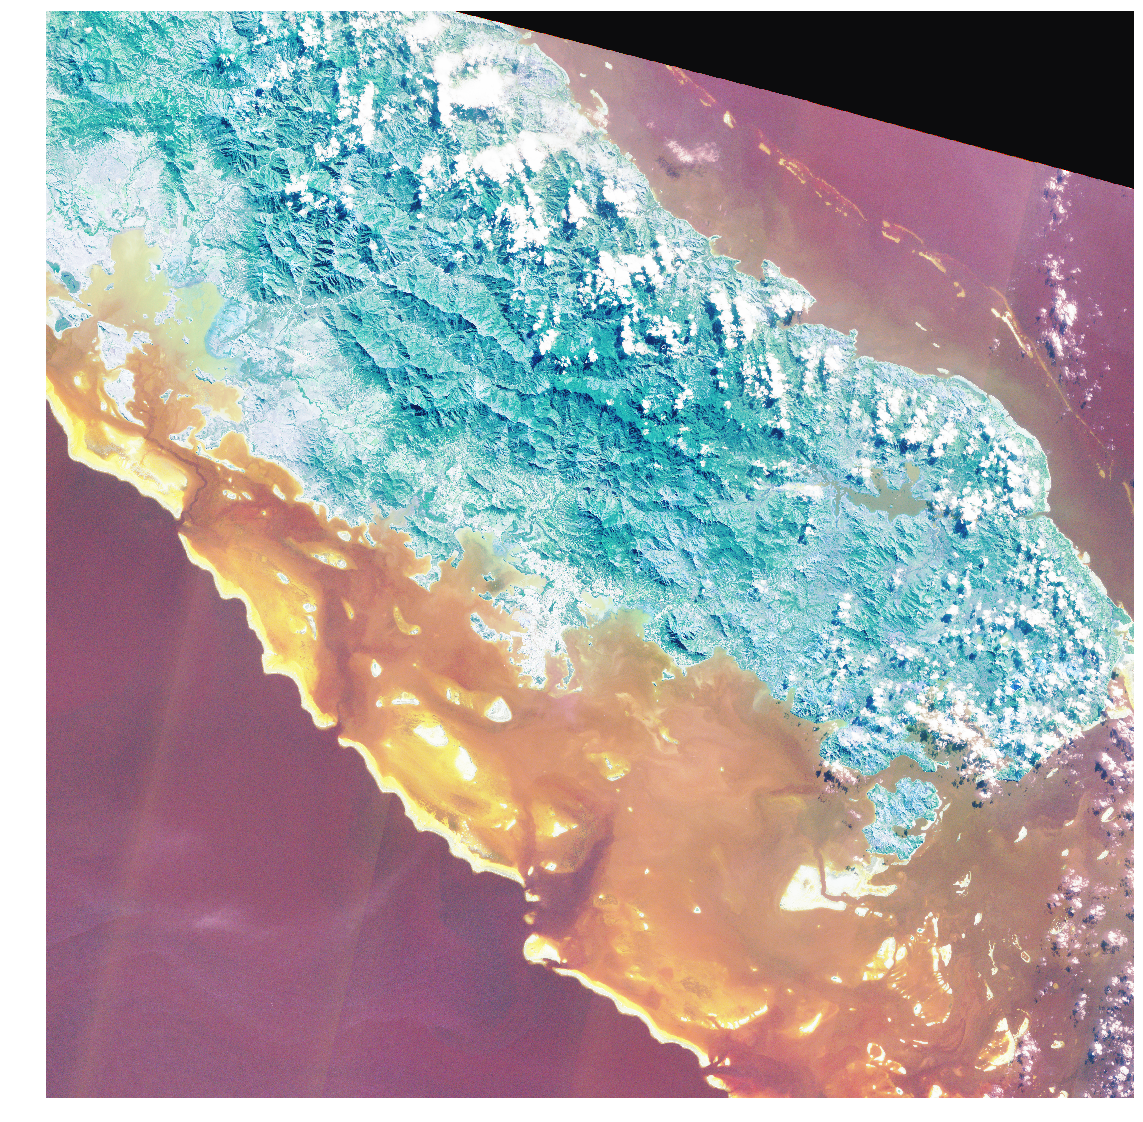

In [13]:
plot_img = np.empty(RGB_img.shape, dtype=float)
for i in range(plot_img.shape[2]):
    plot_img[:,:,i] = exposure.equalize_hist(img_as_float(RGB_img[:,:,2-i]))
    
plt.figure(figsize=(20, 20))
#plt.subplot(1, 2, 1)
plt.imshow(plot_img)
#plt.subplot(1, 2, 2)
#plt.imshow(Random)
plt.axis('off')
plt.show


In [19]:
p_NIR = [10,60,60,80,70,75,90,68,55,35]
Buffer = np.full(RGB_img.shape, 0 , dtype= RGB_img.dtype)
SoilIndex = np.full(RGB_img.shape[0:2] , False, dtype= bool)

for i in range(len(FootPrint)):
    v_NIR = np.percentile(NIR[FootPrint[i]].ravel(), (p_NIR[i]))
    print('percentiles ',p_NIR[i],', of FootPrint ',str(i),': ',str(v_NIR),'\n')
    SoilIndex[np.logical_and(FootPrint[i], NIR>v_NIR)] = True
    
SoilIndex = morphology.remove_small_holes(SoilIndex, 100000)
SoilIndex = np.logical_not(morphology.remove_small_holes(~SoilIndex, 100))
SoilIndex = np.tile(SoilIndex[:,:,np.newaxis], (1,1,3))
Buffer[SoilIndex] = RGB_img[SoilIndex]
    
write_raster2(FilePath+'/Mask2/'+'10m.tif', SoilIndex[:,:,0], ds[0].GetGeoTransform(), ds[0].GetProjection(), DriverName="GTiff", formatMem=gdal.GDT_Byte)
Mask = []
Mask.append(gdal.Open( FilePath+'/Mask2/'+'10m.tif'))
res = [10, 20, 60]
for i in range(1,3):
    # Output / destination
    MaskPath = FilePath+'/Mask2/'+str(res[i])+'m.tif'
    Mask.append(gdal.GetDriverByName('GTiff').Create(MaskPath, ds[i].RasterXSize, ds[i].RasterYSize, 1, gdal.GDT_Byte))
    Mask[i].SetGeoTransform( ds[i].GetGeoTransform())
    Mask[i].SetProjection( ds[i].GetProjection())
    gdal.ReprojectImage(Mask[0], Mask[i], None, None, eResampleAlg=8 )
Mask = None



percentiles  10 , of FootPrint  0 :  1305.0 

percentiles  60 , of FootPrint  1 :  853.0 

percentiles  60 , of FootPrint  2 :  108.0 

percentiles  80 , of FootPrint  3 :  1159.0 

percentiles  70 , of FootPrint  4 :  549.0 

percentiles  75 , of FootPrint  5 :  635.0 

percentiles  90 , of FootPrint  6 :  286.0 

percentiles  68 , of FootPrint  7 :  630.0 

percentiles  55 , of FootPrint  8 :  496.0 

percentiles  35 , of FootPrint  9 :  727.0 



In [ ]:
plt.figure(figsize=(15, 15))
#plt.subplot(1, 2, 1)
plt.imshow(SoilIndex[:,:,0])
#plt.subplot(1, 2, 2)
#plt.imshow(Random)
plt.axis('off')
plt.show